#### Import dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import PyPDF2
import io
import cmocean
import multiprocessing
from pdfo import pdfo,Bounds

import xarray as xr

xr.set_options(display_style='html')

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

## Response parameters

In [2]:
response_df = pd.read_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv',index_col=0)

In [44]:
def BuildMat(params):
#     param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_2x']
    A = np.array([[-1*params[0],0,0,0],\
                     [1/params[1],-1*(params[4]+params[5])/params[1],params[5]/params[1],0],\
                     [0,params[5]/params[2],-1*(params[5]+params[7]*params[6])/params[2],params[7]*params[6]/params[2]],\
                     [0,0,params[6]/params[3],-1*params[6]/params[3]]])
    k = A.shape[0]
    b = np.array([params[0],0,0,0]).T
    Q = np.zeros((4,4))
    Q[0,0] = params[8]**2
    Q[1,1] = (params[9]/params[1])**2
    A_d = sp.linalg.expm(A)
    b_d = sp.linalg.solve(A, (A_d - np.identity(k)) @ b)
    ## use Van Loan (1978) to compute the matrix exponential
    H = np.zeros((k*2,k*2))
    H[:k,:k] = -A
    H[:k,k:] = Q
    H[k:,k:] = A.T
    G = sp.linalg.expm(H)
    Q_d = G[k:,k:].T @ G[:k,k:]
    C_d = np.array([[0,1,0,0],\
                   [1,-1*params[4],(1-params[7])*params[6],-1*(1-params[7])*params[6]]])
    
    return A,b,Q,A_d,b_d,Q_d,C_d

def convert_geoffrey_to_FaIR(params):
#     ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_4x']

    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(params)
    eigval,eigvec = np.linalg.eig(A[1:,1:])
    tau = -1/eigval
    q = tau * ( eigvec[0,:] * np.linalg.inv(eigvec)[:,0] ) / params[1]
    
    order = np.argsort(tau)
    
    return pd.DataFrame([tau[order],q[order]],index=['d','q'],columns=[1,2,3])

In [45]:
response_df.loc['ECS'] = np.nan
response_df.loc['TCR'] = np.nan
for model in response_df.columns:
    fair_params = pd.concat([convert_geoffrey_to_FaIR(response_df.loc[:'F_4x',model].values)],axis=1,keys=[model])
    response_df.loc[['ECS','TCR'],model] = q_to_tcr_ecs(fair_params,F_2x = response_df.loc['F_2x',model]).iloc[:,0]
response_df.loc['RWF'] = response_df.loc['TCR'] / response_df.loc['ECS']

In [64]:
response_df.loc[['ECS','TCR','RWF']].quantile([0.05,0.5,0.95],axis=1)

,ECS,TCR,RWF
0.05,1.944262,1.345492,0.358217
0.50,3.978415,2.035489,0.536326
0.95,6.107794,2.713025,0.762762


In [47]:
response_df.loc[['ECS','TCR','RWF']].T.corr()

,ECS,TCR,RWF
ECS,1.000000,0.634168,-0.890351
TCR,0.634168,1.000000,-0.296308
RWF,-0.890351,-0.296308,1.000000


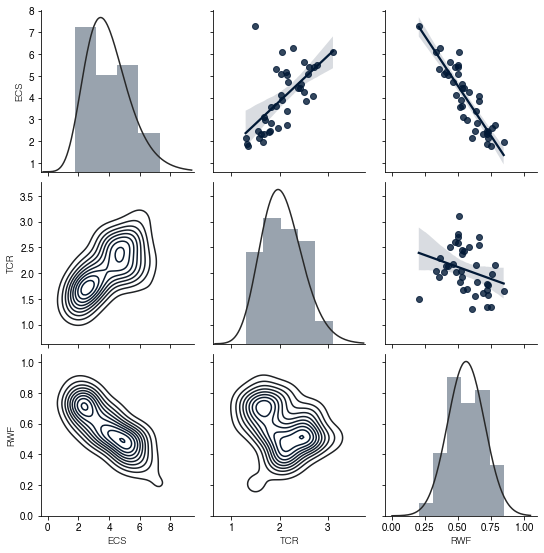

In [48]:
g = sn.PairGrid(response_df.loc[['ECS','TCR','RWF']].T,diag_sharey=False)

g.map_upper(sn.regplot)
g.map_lower(sn.kdeplot)
g.map_diag(sn.distplot,kde=False,fit=sp.stats.lognorm)

In [53]:
fair_param_df = pd.concat([convert_geoffrey_to_FaIR(x.iloc[:10]) for y,x in response_df.iteritems()],axis=1,keys=response_df.columns)

fair_params_stats = pd.DataFrame(fair_param_df.unstack().reset_index().set_index(['level_2','level_1','level_0']).unstack(2)[0].T.reset_index().values,columns=['model','d1','d2','d3','q1','q2','q3']).set_index('model').apply(pd.to_numeric)

In [54]:
for param in fair_params_stats.columns:
    fair_params_stats['ln_'+param] = np.log(fair_params_stats[param])
fair_params_stats['ECS'] = response_df.loc['ECS']
fair_params_stats['TCR'] = response_df.loc['TCR']
fair_params_stats['RWF'] = response_df.loc['RWF']

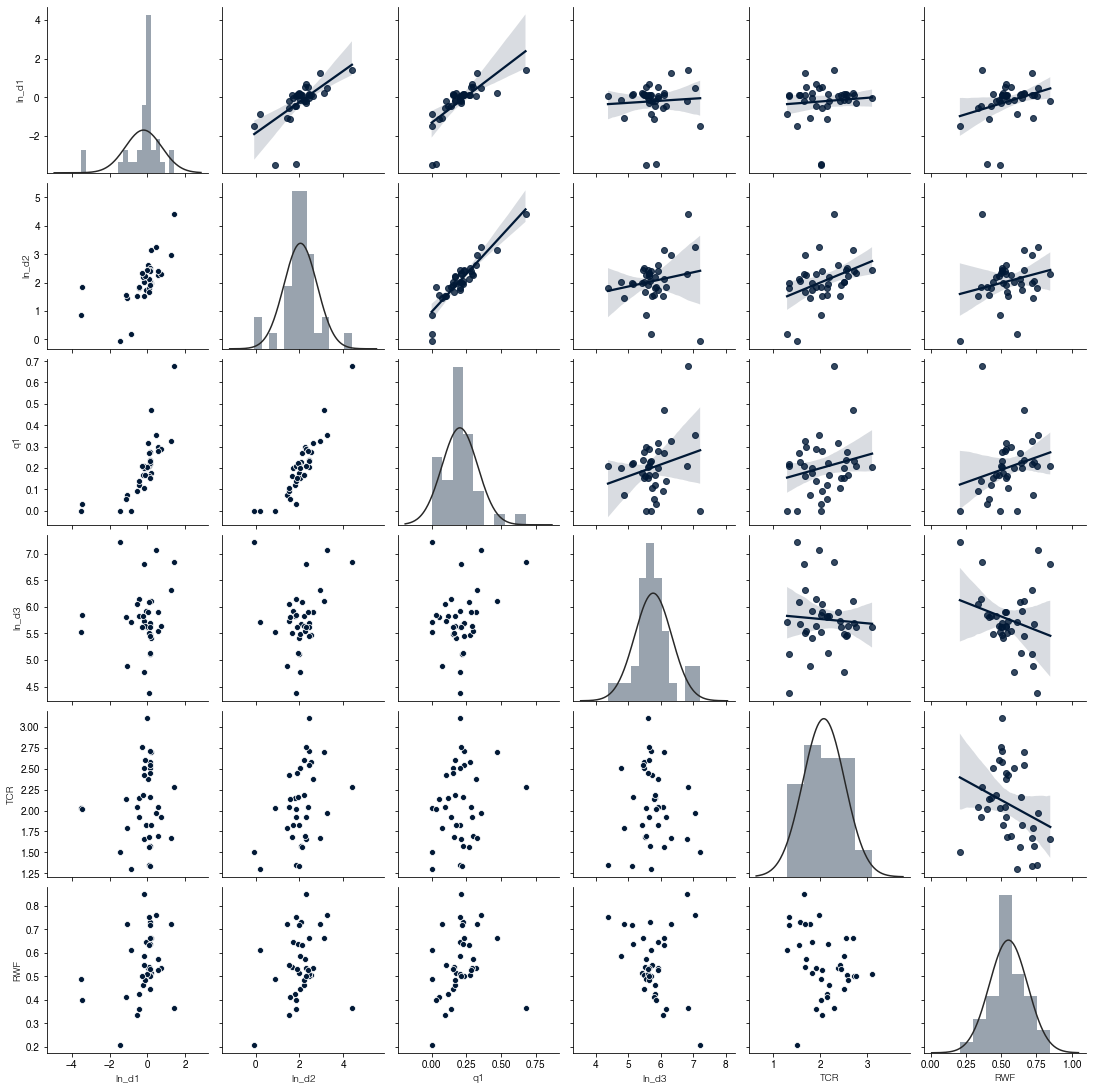

In [79]:
outliers = ['MPI-ESM1-2-LR','GISS-E2-1-H','NorCPM1']

no_outliers = set(fair_params_stats.index).symmetric_difference(set(outliers))

g = sn.PairGrid(fair_params_stats.loc[no_outliers,['ln_d1','ln_d2','q1','ln_d3','TCR','RWF']],diag_sharey=False)

g.map_upper(sn.regplot)
g.map_lower(sn.scatterplot)
g.map_diag(sn.distplot,kde=False,fit=sp.stats.norm)

<AxesSubplot:>

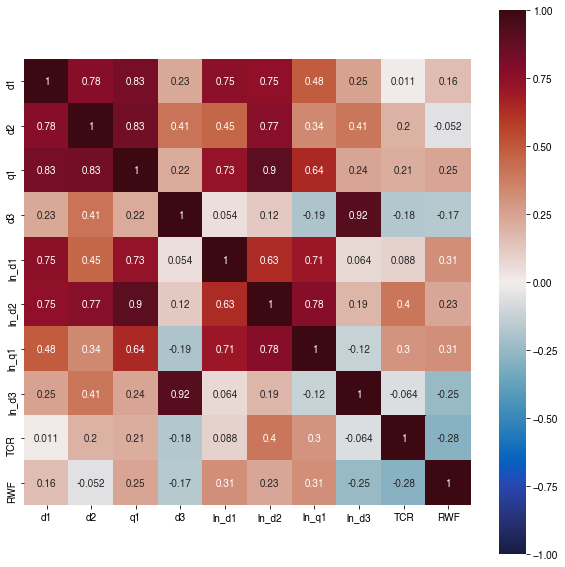

In [76]:
plt.figure(figsize=(10,10))
sn.heatmap(fair_params_stats.loc[no_outliers,['d1','d2','q1','d3','ln_d1','ln_d2','ln_q1','ln_d3','TCR','RWF']].corr(method='pearson'),square=True,annot=True,cmap=cmocean.cm.balance,vmin=-1,vmax=1)

#### Sampling response parameters based on the no-outlier CMIP6 sample

- sample ln_d1, ln_d2, q1 as a multivariate normal
- sample ln_d3 normally + independently
- sample TCR normally + independently
- sample RWF normally + independently

In [127]:
# required covariance matrices, means, stdevs:
print('lnd1,lnd2,q1 covariance\n',fair_params_stats.loc[no_outliers,['ln_d1','ln_d2','q1']].cov().values)
print('lnd1,lnd2,q1 mean\n',fair_params_stats.loc[no_outliers,['ln_d1','ln_d2','q1']].mean().values)
print('\nlnd3 std\n',fair_params_stats.loc[no_outliers,['ln_d3']].std().values)
print('lnd3 mean\n',fair_params_stats.loc[no_outliers,['ln_d3']].mean().values)
print('\nTCR std\n',fair_params_stats.loc[no_outliers,['TCR']].std().values)
print('TCR mean\n',fair_params_stats.loc[no_outliers,['TCR']].mean().values)
print('\nRWF std\n',fair_params_stats.loc[no_outliers,['RWF']].std().values)
print('RWF mean\n',fair_params_stats.loc[no_outliers,['RWF']].mean().values)

lnd1,lnd2,q1 covariance
 [[0.95199915 0.47649902 0.09359745]
 [0.47649902 0.59388914 0.09119872]
 [0.09359745 0.09119872 0.01710808]]
lnd1,lnd2,q1 mean
 [-0.20227299  2.05243353  0.20285564]

lnd3 std
 [0.57722689]
lnd3 mean
 [5.76338587]

TCR std
 [0.45012178]
TCR mean
 [2.0782074]

RWF std
 [0.13777385]
RWF mean
 [0.55124171]


# Carbon cycle parameters

In [102]:
cmip6_cc_params = pd.read_csv('../Parameter_Sets/CMIP6_1pctCO2_cc_12082020.csv',index_col=0)

<AxesSubplot:>

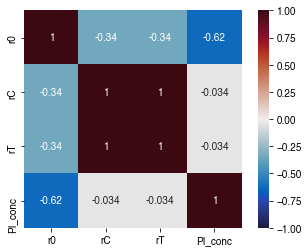

In [107]:
sn.heatmap(cmip6_cc_params.corr(method='pearson'),square=True,annot=True,cmap=cmocean.cm.balance,vmin=-1,vmax=1)

# Aerosol ERF parameters

In [116]:
ERFaci_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFaci.csv',index_col=0)
ERFari_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFari.csv',index_col=0)

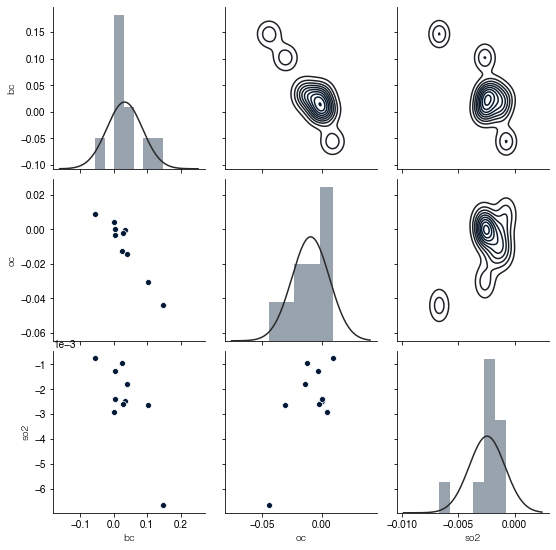

In [123]:
g = sn.PairGrid(ERFari_params,diag_sharey=False)

g.map_upper(sn.kdeplot)
g.map_lower(sn.scatterplot)
g.map_diag(sn.distplot,kde=False,fit=sp.stats.norm)

For ERFari, we draw a set of multivariate normal parameters

In [126]:
print('bc,oc,so2 covariance\n',ERFari_params.cov().values)
print('bc,oc,so2 mean\n',ERFari_params.mean().values)

bc,oc,so2 covariance
 [[ 3.15369655e-03 -8.82303049e-04 -7.48817290e-05]
 [-8.82303049e-04  2.73438810e-04  1.93224159e-05]
 [-7.48817290e-05  1.93224159e-05  2.79943211e-06]]
bc,oc,so2 mean
 [ 0.0322228  -0.00942092 -0.00244355]


<AxesSubplot:>

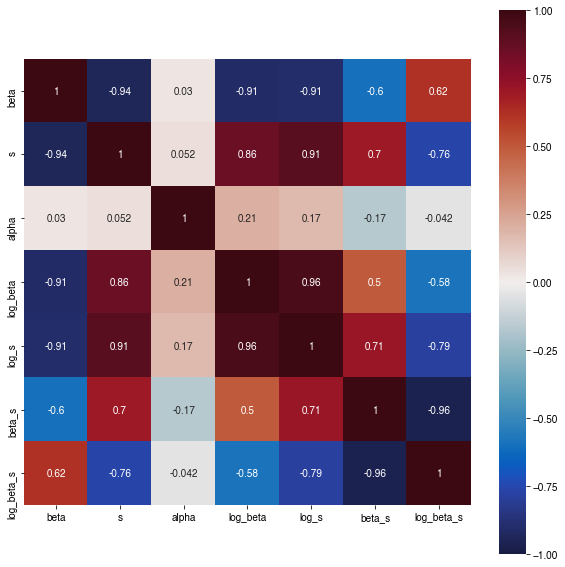

In [130]:
plt.figure(figsize=(10,10))
sn.heatmap(ERFaci_params.corr(method='pearson'),square=True,annot=True,cmap=cmocean.cm.balance,vmin=-1,vmax=1)

For ERFaci, we draw ln beta & ln beta/s as a multivariate normal, and alpha as an independent normal

In [138]:
print('ln beta, ln beta/s covariance\n',ERFaci_params.loc[:,['log_beta','log_beta_s']].cov().values)
print('ln beta, ln beta/s mean\n',ERFaci_params.loc[:,['log_beta','log_beta_s']].mean().values)
print('\nalpha stdev\n',ERFaci_params.loc[:,'alpha'].std())
print('alpha mean\n',ERFaci_params.loc[:,'alpha'].mean())

ln beta, ln beta/s covariance
 [[ 1.91733923 -0.50602743]
 [-0.50602743  0.39434683]]
ln beta, ln beta/s mean
 [ 0.34360154 -4.83319076]

alpha stdev
 0.00708497464821015
alpha mean
 -0.01052545531769231


## Carbon cycle parameters

In [145]:
cc_params = pd.read_csv('../Parameter_Sets/CMIP6_1pctCO2_cc_15082020_indep_rCrT.csv')

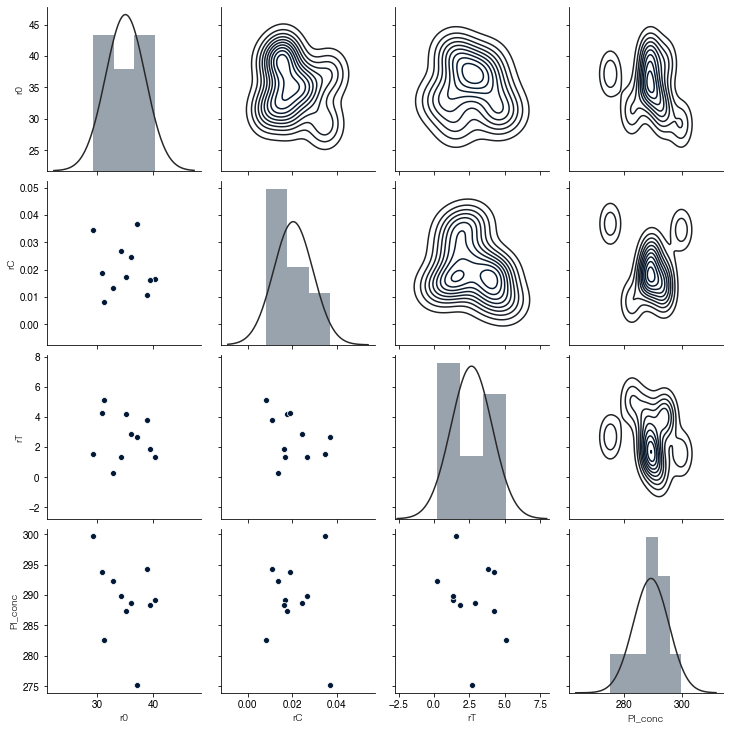

In [146]:
g = sn.PairGrid(cc_params,diag_sharey=False)

g.map_upper(sn.kdeplot)
g.map_lower(sn.scatterplot)
g.map_diag(sn.distplot,kde=False,fit=sp.stats.norm)

<AxesSubplot:>

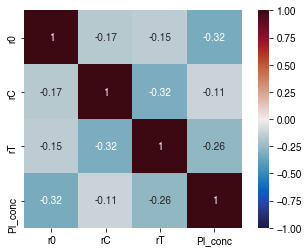

In [147]:
sn.heatmap(cc_params.corr(method='pearson'),square=True,annot=True,cmap=cmocean.cm.balance,vmin=-1,vmax=1)